# calculating and plotting climate exceedance values

In [1]:
# import packages

import requests 
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime

import lmoments3 as lm
from lmoments3 import distr

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## pulling and formatting climate data

In [2]:
ds = xr.open_dataset("./data/pr_Amon_NorESM1-M_historical_r1i1p1_185001-200512.nc")
print(ds)

<xarray.Dataset>
Dimensions:    (time: 1872, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2005-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/26)
    institution:            Norwegian Climate Centre
    institute_id:           NCC
    experiment_id:          historical
    source:                 NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Oslo-n...
    model_id:               NorESM1-M
    forcing:                GHG, SA, Oz, Sl, Vl, BC, OC
    ...                     ...
    table_id:               Table Amon (27 April 2011) a5a1c518f52ae340313ba0...
    title:                  NorESM1-M mo

In [22]:
# converting precipitation to m/day units

ds['pr'].data = ds['pr'].data * 86.4
ds['pr'].attrs['units'] = 'm/day' 

In [28]:
# creating a data array

da = ds['pr']
da

<xarray.DataArray 'pr' (time: 1872, lat: 96, lon: 144)>
array([[[0.00555023, 0.00555023, 0.00555023, ..., 0.00555023,
         0.00555023, 0.00555023],
        [0.00600878, 0.00581785, 0.00592599, ..., 0.00582493,
         0.00636514, 0.00653203],
        [0.00970045, 0.00971113, 0.0099291 , ..., 0.0100328 ,
         0.00987756, 0.00942897],
        ...,
        [0.04257605, 0.0429193 , 0.04189436, ..., 0.04391673,
         0.04373389, 0.04313667],
        [0.01732617, 0.01786654, 0.01875403, ..., 0.01607114,
         0.016471  , 0.01644039],
        [0.0151947 , 0.0151947 , 0.0151947 , ..., 0.0151947 ,
         0.0151947 , 0.0151947 ]],

       [[0.0046706 , 0.0046706 , 0.0046706 , ..., 0.0046706 ,
         0.0046706 , 0.0046706 ],
        [0.00899983, 0.00919608, 0.00890308, ..., 0.0099112 ,
         0.00997502, 0.0094276 ],
        [0.01567418, 0.01461089, 0.01362612, ..., 0.01867234,
         0.01782551, 0.01688543],
...
        [0.05964848, 0.05857263, 0.05915041, ..., 0.05438375,
         0.05631456, 0.05697314],
        [0.04484332, 0.04545097, 0.04546867, ..., 0.04264763,
         0.04337803, 0.04503936],
        [0.03025415, 0.03025411, 0.03025407, ..., 0.03025408,
         0.03025414, 0.03025422]],

       [[0.00481314, 0.00481314, 0.00481314, ..., 0.00481314,
         0.00481314, 0.00481314],
        [0.00576219, 0.00557839, 0.00731522, ..., 0.00599431,
         0.00554346, 0.00581228],
        [0.01117799, 0.01036949, 0.00979722, ..., 0.01106523,
         0.01078128, 0.01123105],
        ...,
        [0.05381381, 0.05633192, 0.05819392, ..., 0.0459496 ,
         0.04836231, 0.05089733],
        [0.05504007, 0.05472219, 0.05590733, ..., 0.04709857,
         0.05010578, 0.05159757],
        [0.0298089 , 0.0298089 , 0.0298089 , ..., 0.0298089 ,
         0.0298089 , 0.0298089 ]]], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2005-12-16 12:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    standard_name:     precipitation_flux
    long_name:         Precipitation
    comment:           at surface; includes both liquid and solid phases from...
    units:             m/day
    original_name:     PRECT
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2011-06-01T05:45:35Z altered by CMOR: Converted type f...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

## defining exceedance and return value functions

In [29]:
def get_return_value(y, return_year=10):
    ams = y.groupby('time.year').max('time')
    paras = distr.gev.lmom_fit(ams)
    fitted_gev = distr.gev(**paras)
    return_period = 1.0-(1./return_year)
    
    return_value = fitted_gev.ppf(return_period)
    return_value = round(return_value, 5)
    return xr.DataArray(return_value)

def get_exceedance(y, exceedance):
    ams = y.groupby('time.year').max('time')
    paras = distr.gev.lmom_fit(ams)
    fitted_gev = distr.gev(**paras)
    
    exceedance_probability = 1-(fitted_gev.cdf(exceedance))
    return xr.DataArray(exceedance_probability)

## applying get_return_value function and plotting return values

In [30]:
da_stacked = da.stack(allpoints=['lon','lat']).squeeze()

In [31]:
return_values = da_stacked.groupby('allpoints').apply(get_return_value, 
                                                      return_year=10)

In [32]:
return_values = return_values.unstack('allpoints').transpose()

/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_m

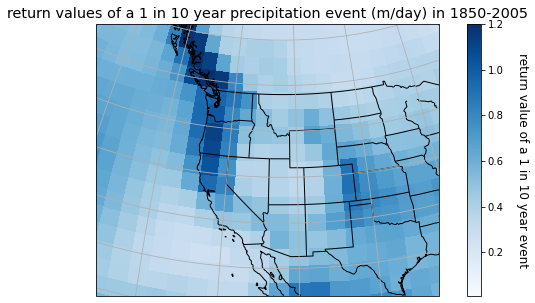

In [33]:
fig = plt.figure(figsize=[10,5])
ax = plt.subplot(111,projection=ccrs.Orthographic(-112,42))

plotted_data = ax.pcolormesh(return_values.lon, return_values.lat,
                             return_values,
                             transform=ccrs.PlateCarree(),
                             cmap=cm.Blues, vmax=1.2)

cbar = fig.colorbar(plotted_data)

ax.set_extent([-135,-93,25,55])
ax.coastlines() 
ax.gridlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                    name='admin_1_states_provinces_lines',
                                    scale='110m',facecolor='None'),
               edgecolor='k')

cbar.ax.set_ylabel('return value of a 1 in 10 year event',
                   fontsize='large',
                   labelpad=25,
                   rotation=270)
ax.set_title('return values of a 1 in 10 year precipitation event (m/day) in 1850-2005',
             fontsize='x-large')

plt.show()

## applying get_exceedance function and plotting exceedance

In [34]:
exceedance = da_stacked.groupby('allpoints').apply(get_exceedance, 
                                                      exceedance=0.5)

In [35]:
exceedance = exceedance.unstack('allpoints').transpose()

/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_m

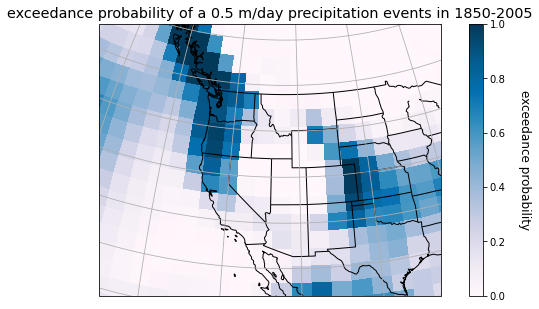

In [36]:
fig = plt.figure(figsize=[10,5])
ax = plt.subplot(111,projection=ccrs.Orthographic(-112,42))

plotted_data = ax.pcolormesh(exceedance.lon, exceedance.lat,
                             exceedance,
                             transform=ccrs.PlateCarree(),
                             cmap=cm.PuBu)

cbar = fig.colorbar(plotted_data)

ax.set_extent([-135,-93,25,55])
ax.coastlines() 
ax.gridlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                    name='admin_1_states_provinces_lines',
                                    scale='110m',facecolor='None'),
               edgecolor='k')

cbar.ax.set_ylabel('exceedance probability',
                   fontsize='large',
                   labelpad=25,
                   rotation=270)
ax.set_title('exceedance probability of a 0.5 m/day precipitation events in 1850-2005',
             fontsize='x-large')

plt.show()

## comparing return values across two different time periods

In [37]:
#split dataset into two parts

da_1850_1950 = da.sel(time=slice("1850-01-01", "1950-01-01"))
da_1950_2005 = da.sel(time=slice("1950-01-01", "2005-01-01"))

In [38]:
da_1850_1950 = da_1850_1950.stack(allpoints=['lon','lat']).squeeze()
da_1950_2005 = da_1950_2005.stack(allpoints=['lon','lat']).squeeze()

In [39]:
da_1850_1950 = da_1850_1950.groupby('allpoints')
da_1950_2005 = da_1950_2005.groupby('allpoints')

In [41]:
return_values_1850_1950 = da_1850_1950.apply(get_return_value, return_year=10)
return_values_1950_2005 = da_1950_2005.apply(get_return_value, return_year=10)

In [42]:
return_values_1850_1950 = return_values_1850_1950.unstack('allpoints').transpose()
return_values_1950_2005 = return_values_1950_2005.unstack('allpoints').transpose()

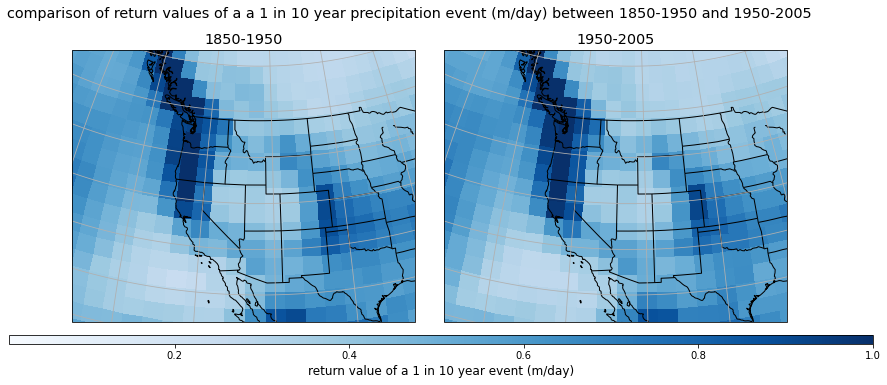

In [45]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[20,6], subplot_kw={"projection": ccrs.Orthographic(-112,42)})
fig.suptitle('comparison of return values of a a 1 in 10 year precipitation event (m/day) between 1850-1950 and 1950-2005 ', fontsize='x-large')


cf1 = ax1.pcolormesh(return_values_1850_1950.lon, return_values_1850_1950.lat, 
                             return_values_1850_1950,
                             transform=ccrs.PlateCarree(),
                             cmap=cm.Blues, vmax=1)
ax1.set_extent([-135,-93,25,55])
ax1.coastlines() 
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                    name='admin_1_states_provinces_lines',
                                    scale='110m',facecolor='None'),
               edgecolor='k')
ax1.set_title('1850-1950',
             fontsize='x-large')


cf2 = ax2.pcolormesh(return_values_1950_2005.lon, return_values_1950_2005.lat, 
                             return_values_1950_2005,
                             transform=ccrs.PlateCarree(),
                             cmap=cm.Blues, vmax=1)
ax2.set_extent([-135,-93,25,55])
ax2.coastlines() 
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                    name='admin_1_states_provinces_lines',
                                    scale='110m',facecolor='None'),
               edgecolor='k')
ax2.set_title('1950-2005',
             fontsize='x-large')


fig.subplots_adjust(bottom=0.25, wspace=-0.5)
cbar_ax = fig.add_axes([0.22, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cf2, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('return value of a 1 in 10 year event (m/day)', fontsize='large')

plt.show()